In [1]:
!pip install coppeliasim-zmqremoteapi-client


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Imports

In [2]:
import sys
import coppeliasim_zmqremoteapi_client
import time
import math
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import numpy as np

In [3]:
sys.path.append(r"D:\CoppeliaRobotics\CoppeliaSimEdu\programming\zmqRemoteApi\clients\python")

# Initial Setup

In [ ]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

client = RemoteAPIClient()
sim = client.getObject('sim')

sim.startSimulation()
print("Simulation started...")
time.sleep(3)
sim.stopSimulation()
print("Simulation stopped successfully!")

Simulation started...
Simulation stopped successfully!


# Initializing Objects

In [14]:
base_handle = sim.getObject('/Endurance')
wheel_names = ['/front_left_wheel', '/front_right_wheel','/back_left_wheel','/back_right_wheel']
wheel_handles = [sim.getObject(n) for n in wheel_names]

# Handler Functions

## Object Handlers

In [ ]:
def set_wheel_velocities(v_fl, v_fr, v_rl, v_rr):
    sim.setJointTargetVelocity(wheel_handles[0], v_fl)
    sim.setJointTargetVelocity(wheel_handles[1], -v_fr)
    sim.setJointTargetVelocity(wheel_handles[2], v_rl)
    sim.setJointTargetVelocity(wheel_handles[3], -v_rr)

def set_all_wheels(v):
    set_wheel_velocities(v, v, v, v)

def set_wheel_speeds(lin_speed, ang_speed):
    v_left = lin_speed - ang_speed
    v_right = lin_speed + ang_speed
    sim.setJointTargetVelocity(wheel_handles[0], v_left)   # front-left
    sim.setJointTargetVelocity(wheel_handles[1], -v_right)  # front-right
    sim.setJointTargetVelocity(wheel_handles[2], v_left)   # rear-left
    sim.setJointTargetVelocity(wheel_handles[3], -v_right)  # rear-right


def stop_wheels():
    set_all_wheels(0.0)

def get_base_position():
    return sim.getObjectPosition(base_handle, -1) 

def get_base_yaw():
    ori = sim.getObjectOrientation(base_handle, -1)
    return ori[2]

def angle_diff(a, b):
    d = (a - b + math.pi) % (2*math.pi) - math.pi
    return d


## Motion Handlers

In [ ]:
def rotate_in_place(direction=1, rot_speed=2.0, duration=None, until_angle=None):
    left_vel = -direction * rot_speed
    right_vel = direction * rot_speed

    if until_angle is None:
        set_wheel_velocities(left_vel, right_vel, left_vel, right_vel)
        time.sleep(duration)
        stop_wheels()
    else:
        while True:
            yaw = get_base_yaw()
            d = angle_diff(until_angle, yaw)
            if abs(d) < 0.05:
                break
            set_wheel_velocities(left_vel, right_vel, left_vel, right_vel)
            time.sleep(0.01)
        stop_wheels()


# Controllers

### Stuck Recovery Logic

In [ ]:
def perform_stuck_recovery(target_xy, stuck_check_fn):
    print("Stuck detected — starting recovery sequence...")
    stop_wheels()
    time.sleep(0.1)

    for _ in range(3):
        set_wheel_velocities(-3.5, -2.5, -3.5, -2.5)
        time.sleep(0.4)
        set_wheel_velocities(-2.5, -3.5, -2.5, -3.5)
        time.sleep(0.4)
        stop_wheels()
        time.sleep(0.1)
        if not stuck_check_fn():
            print("Freed during reverse oscillation.")
            return
    base_pos = get_base_position()
    base_yaw = get_base_yaw()
    dx, dy = target_xy[0] - base_pos[0], target_xy[1] - base_pos[1]
    target_angle = math.atan2(dy, dx)
    angle_to_target = angle_diff(target_angle, base_yaw)
    direction = 1 if angle_to_target > 0 else -1

    print(f"↪ Rotating {('left' if direction==1 else 'right')} toward target.")
    rotate_in_place(direction=direction, rot_speed=4.5, duration=0.8)
    stop_wheels()
    time.sleep(0.2)
    if not stuck_check_fn():
        print("Freed after reorientation.")
        return

    print("Recovery complete — resuming navigation.")


### Discrete Stepwise Controller

In [ ]:
def goto_point_recover(target_xy,
                       forward_speed=2.0, rotate_speed=1.2,
                       dist_tolerance=0.20, obstacle_threshold=0.5,
                       stuck_threshold_time=1.5, stuck_min_progress=0.02,
                       log_fn=None):
    tx, ty = target_xy
    it = 0
    last_pos = get_base_position()
    last_progress_time = time.time()

    while True:
        if log_fn is not None:
            log_fn()

        it+=1
        x, y, _ = get_base_position()
        dx = tx - x
        dy = ty - y
        dist = math.hypot(dx, dy)

        if dist <= dist_tolerance:
            stop_wheels()
            print("✅ Reached target.")
            return True
        
        target_yaw = math.atan2(dy, dx)
        yaw = get_base_yaw()
        dtheta = angle_diff(target_yaw, yaw)
        movement = math.hypot(x - last_pos[0], y - last_pos[1])
        if movement > stuck_min_progress:
            last_progress_time = time.time()
            last_pos = (x, y)
        elif (time.time() - last_progress_time) > stuck_threshold_time:
            print("Rover seems stuck - performing recovery...")
            stop_wheels()
            for _ in range(10):
                set_all_wheels(-1.5)
                time.sleep(0.1)
            stop_wheels()
            rot_dir = 1 if dtheta <= 0 else -1
            rotate_in_place(direction=rot_dir, rot_speed=rotate_speed, duration=0.1)
            stop_wheels()
            last_progress_time = time.time()
            last_pos = get_base_position()
            continue

        if abs(dtheta) > 0.5:
            stop_wheels()
            rot_dir = 1 if dtheta > 0 else -1
            rotate_in_place(direction=rot_dir, rot_speed=rotate_speed, duration=0.1)
        else:
            set_all_wheels(forward_speed)
            time.sleep(0.1)

        print(f"[{it:03}] dist={dist:.2f}, head_err={dtheta:.2f}, pos=({log[-1]})")

# Main Script for ENV 1 - run + log + plot path

Going to sample...
[001] dist=22.74, head_err=0.79, pos=([9.325, -9.312, 1.154, 0.22])
[002] dist=22.74, head_err=0.79, pos=([9.326, -9.31, 0.894, 0.5])
[003] dist=22.78, head_err=0.74, pos=([9.327, -9.368, 0.728, 0.82])
[004] dist=22.82, head_err=0.54, pos=([9.331, -9.417, 0.738, 1.04])
[005] dist=22.83, head_err=0.34, pos=([9.311, -9.446, 0.728, 1.28])
[006] dist=22.79, head_err=0.21, pos=([9.265, -9.44, 0.717, 1.53])
[007] dist=22.73, head_err=0.13, pos=([9.219, -9.397, 0.725, 1.73])
[008] dist=22.65, head_err=0.08, pos=([9.167, -9.334, 0.72, 1.91])
[009] dist=22.55, head_err=0.03, pos=([9.107, -9.255, 0.697, 2.1])
[010] dist=22.44, head_err=-0.03, pos=([9.026, -9.184, 0.705, 2.34])
[011] dist=22.33, head_err=-0.10, pos=([8.945, -9.111, 0.71, 2.92])
[012] dist=22.23, head_err=-0.15, pos=([8.87, -9.045, 0.714, 3.1])
[013] dist=22.17, head_err=-0.18, pos=([8.821, -9.005, 0.719, 3.22])
[014] dist=22.07, head_err=-0.23, pos=([8.737, -8.951, 0.717, 3.38])
[015] dist=21.98, head_err=-0.29

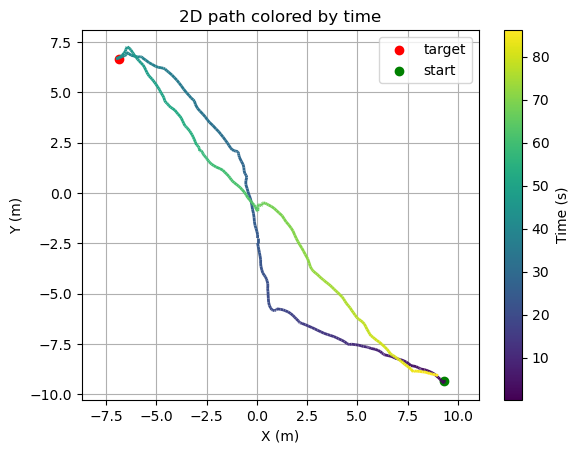

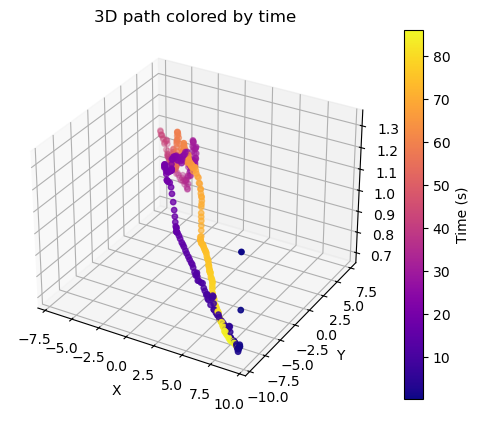

In [ ]:
start = sim.getObject('/Start')
target = sim.getObject('/Target')

start_xyz = sim.getObjectPosition(start, -1) # OG: [9.325, -9.35, 0.39625]
target_xyz = sim.getObjectPosition(target, -1) # OG: [-6.85, 6.675, 0.69375]

start_xy = start_xyz[:2]
target_xy = target_xyz[:2]


sim.startSimulation()
sim_start_time = time.time()
time.sleep(0.2)


def log_current_position():
    pos = get_base_position()  # [x, y, z]
    elapsed = time.time() - sim_start_time
    log.append([round(pos[0], 3), round(pos[1], 3), round(pos[2], 3), round(elapsed, 2)])


print("Starting Env1...")
log = []
# ok = goto_point_vector(target_xy,max_lin_speed=10, max_ang_speed=8 ,log_fn=log_current_position)
ok = goto_point_recover(target_xy, forward_speed=12.0, rotate_speed=8.0, dist_tolerance=0.1,log_fn=log_current_position)

if not ok:
    print("Could not reach sample (timeout). Aborting mission.")
    stop_wheels()
else:
    stop_wheels()
    print("Reached sample. Stopping.")
    print("Returning to start...")
    ok = goto_point_recover(start_xy, forward_speed=10.0, rotate_speed=8.0, dist_tolerance=0.5, log_fn=log_current_position)

    if not ok:
        print("Could not return to start (timeout). Aborting mission.")
        stop_wheels()
    else:
        stop_wheels()
        print("Returned to start. Stopping.")


time.sleep(0.2)
sim.stopSimulation()

csv_path = "rover_path_env1.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(['x','y','z','t'])
    writer.writerows(log)
print("Saved path to", csv_path)

if len(log) > 0:
    log_array = np.array(log)
    xs, ys, zs, ts = log_array[:,0], log_array[:,1], log_array[:,2], log_array[:,3]

    #2d
    plt.figure()
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    from matplotlib.collections import LineCollection
    lc = LineCollection(segments, cmap='viridis', linewidths=2)
    lc.set_array(ts)
    plt.gca().add_collection(lc)
    plt.scatter([target_xy[0]], [target_xy[1]], c='r', label='target')
    plt.scatter([start_xy[0]], [start_xy[1]], c='g', label='start')
    plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('2D path colored by time')
    plt.colorbar(lc, label='Time (s)')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

    #3d
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(xs, ys, zs, c=ts, cmap='plasma', s=15)
    fig.colorbar(p, ax=ax, label='Time (s)')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title('3D path colored by time')
    plt.show()


-----------------------------------------------------------------------------------------------